Instructions for updating:
Use `tf.global_variables_initializer` instead.


New data, epoch 0
Step 0 Loss 1.07789
Step 100 Loss 0.0437504
Step 200 Loss 0.0116281
Step 300 Loss 0.00681773
Step 400 Loss 0.00474477
Step 500 Loss 0.00376261
Step 600 Loss 0.00294385
New data, epoch 1
Step 0 Loss 0.18027
Step 100 Loss 0.00223437
Step 200 Loss 0.00196103
Step 300 Loss 0.00181497
Step 400 Loss 0.00158212
Step 500 Loss 0.00144793
Step 600 Loss 0.00133871
New data, epoch 2
Step 0 Loss 0.171503
Step 100 Loss 0.00118173
Step 200 Loss 0.00113368
Step 300 Loss 0.00103945
Step 400 Loss 0.000965106
Step 500 Loss 0.000929068
Step 600 Loss 0.000865472
New data, epoch 3
Step 0 Loss 0.371467
Step 100 Loss 0.000835942
Step 200 Loss 0.00077276
Step 300 Loss 0.000734992
Step 400 Loss 0.000701085
Step 500 Loss 0.000665693
Step 600 Loss 0.000652334
New data, epoch 4
Step 0 Loss 0.427835
Step 100 Loss 0.000623685
Step 200 Loss 0.000598468
Step 300 Loss 0.000574028
Step 400 Loss 0.000568653
Step 500 Loss 0.000558084
Step 600 Loss 0.000520688
New data, epoch 5
Step 0 Loss 0.194499
Step 1

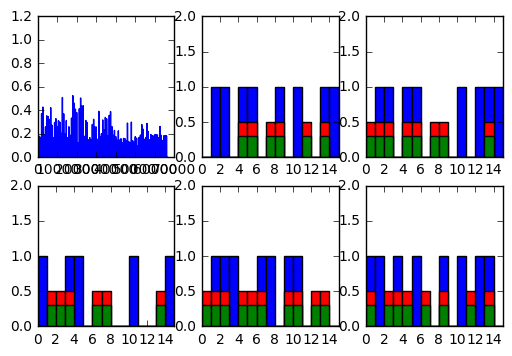

In [1]:
from __future__ import print_function, division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

num_epochs = 100
total_series_length = 50000
truncated_backprop_length = 15
state_size = 4
num_classes = 2
echo_step = 3
batch_size = 5
num_batches = total_series_length//batch_size//truncated_backprop_length

def generateData():
    x = np.array(np.random.choice(2, total_series_length, p=[0.5, 0.5]))
    y = np.roll(x, echo_step)
    y[0:echo_step] = 0

    x = x.reshape((batch_size, -1))  # The first index changing slowest, subseries as rows
    y = y.reshape((batch_size, -1))

    return (x, y)

batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])

init_state = tf.placeholder(tf.float32, [batch_size, state_size])

W = tf.Variable(np.random.rand(state_size+1, state_size), dtype=tf.float32)
b = tf.Variable(np.zeros((1,state_size)), dtype=tf.float32)

W2 = tf.Variable(np.random.rand(state_size, num_classes),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)

# Unpack columns
inputs_series = tf.unstack(batchX_placeholder, axis=1)
labels_series = tf.unstack(batchY_placeholder, axis=1)

# Forward pass
current_state = init_state
states_series = []
for current_input in inputs_series:
    current_input = tf.reshape(current_input, [batch_size, 1])
    input_and_state_concatenated = tf.concat([current_input, current_state], 1)  # Increasing number of columns

    next_state = tf.tanh(tf.matmul(input_and_state_concatenated, W) + b)  # Broadcasted addition
    states_series.append(next_state)
    current_state = next_state

logits_series = [tf.matmul(state, W2) + b2 for state in states_series] #Broadcasted addition
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]

losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels) for logits, labels in zip(logits_series,labels_series)]
total_loss = tf.reduce_mean(losses)

train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

def plot(loss_list, predictions_series, batchX, batchY):
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(5):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")

    plt.draw()
    plt.pause(0.0001)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    plt.ion()
    plt.figure()
    plt.show()
    loss_list = []

    for epoch_idx in range(num_epochs):
        x,y = generateData()
        _current_state = np.zeros((batch_size, state_size))

        print("New data, epoch", epoch_idx)

        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length

            batchX = x[:,start_idx:end_idx]
            batchY = y[:,start_idx:end_idx]

            _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                [total_loss, train_step, current_state, predictions_series],
                feed_dict={
                    batchX_placeholder:batchX,
                    batchY_placeholder:batchY,
                    init_state:_current_state
                })

            loss_list.append(_total_loss)

            if batch_idx%100 == 0:
                print("Step",batch_idx, "Loss", _total_loss)
                plot(loss_list, _predictions_series, batchX, batchY)

plt.ioff()
plt.show()

New data, epoch 0
Step 0 Loss 0.68281
Step 100 Loss 0.0506142
Step 200 Loss 0.00503441
Step 300 Loss 0.0028746
Step 400 Loss 0.00275687
Step 500 Loss 0.00139744
Step 600 Loss 0.000928515
New data, epoch 1
Step 0 Loss 0.130293
Step 100 Loss 0.00161296
Step 200 Loss 0.00149362
Step 300 Loss 0.00103169
Step 400 Loss 0.000788022
Step 500 Loss 0.000787366
Step 600 Loss 0.000647716
New data, epoch 2
Step 0 Loss 0.100812
Step 100 Loss 0.000469214
Step 200 Loss 0.000437063
Step 300 Loss 0.000430489
Step 400 Loss 0.000398373
Step 500 Loss 0.000379387
Step 600 Loss 0.000298922
New data, epoch 3
Step 0 Loss 0.178454
Step 100 Loss 0.000318493
Step 200 Loss 0.000296978
Step 300 Loss 0.000260875
Step 400 Loss 0.000233093
Step 500 Loss 0.000222195
Step 600 Loss 0.000260834
New data, epoch 4
Step 0 Loss 0.171287
Step 100 Loss 0.000182051
Step 200 Loss 0.000205813
Step 300 Loss 0.000239865
Step 400 Loss 0.000217106
Step 500 Loss 0.000188505
Step 600 Loss 0.000181614
New data, epoch 5
Step 0 Loss 0.1003

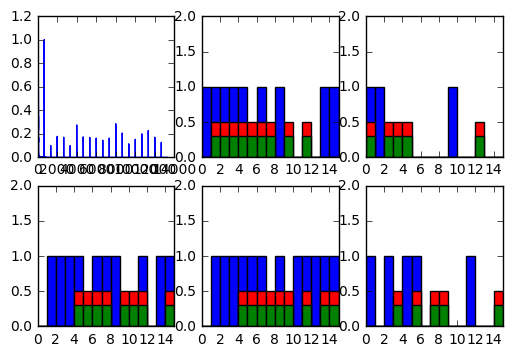

In [1]:
from __future__ import print_function, division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

num_epochs = 20
total_series_length = 50000
truncated_backprop_length = 15
state_size = 4
num_classes = 2
echo_step = 3
batch_size = 5
num_batches = total_series_length//batch_size//truncated_backprop_length

def generateData():
    x = np.array(np.random.choice(2, total_series_length, p=[0.5, 0.5]))
    y = np.roll(x, echo_step)
    y[0:echo_step] = 0

    x = x.reshape((batch_size, -1))  # The first index changing slowest, subseries as rows
    y = y.reshape((batch_size, -1))

    return (x, y)

batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])

init_state = tf.placeholder(tf.float32, [batch_size, state_size])

W = tf.Variable(np.random.rand(state_size+1, state_size), dtype=tf.float32)
b = tf.Variable(np.zeros((1,state_size)), dtype=tf.float32)

W2 = tf.Variable(np.random.rand(state_size, num_classes),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)

# Unpack columns
inputs_series = tf.split(batchX_placeholder, truncated_backprop_length, axis=1)
labels_series = tf.unstack(batchY_placeholder, axis=1)

# Forward pass
# current_state = init_state
# states_series = []
# for current_input in inputs_series:
#     current_input = tf.reshape(current_input, [batch_size, 1])
#     input_and_state_concatenated = tf.concat([current_input, current_state], 1)  # Increasing number of columns

#     next_state = tf.tanh(tf.matmul(input_and_state_concatenated, W) + b)  # Broadcasted addition
#     states_series.append(next_state)
#     current_state = next_state

#================================================
# Forward pass.
cell = tf.contrib.rnn.BasicRNNCell(state_size)
states_series, current_state = tf.contrib.rnn.static_rnn(cell, inputs_series, init_state)
#==================================================

logits_series = [tf.matmul(state, W2) + b2 for state in states_series] #Broadcasted addition
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]

losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels) for logits, labels in zip(logits_series,labels_series)]
total_loss = tf.reduce_mean(losses)

train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

def plot(loss_list, predictions_series, batchX, batchY):
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(5):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")

    plt.draw()
    plt.pause(0.0001)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    plt.ion()
    plt.figure()
    plt.show()
    loss_list = []

    for epoch_idx in range(num_epochs):
        x,y = generateData()
        _current_state = np.zeros((batch_size, state_size))

        print("New data, epoch", epoch_idx)

        for batch_idx in range(num_batches):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length

            batchX = x[:,start_idx:end_idx]
            batchY = y[:,start_idx:end_idx]

            _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                [total_loss, train_step, current_state, predictions_series],
                feed_dict={
                    batchX_placeholder:batchX,
                    batchY_placeholder:batchY,
                    init_state:_current_state
                })

            loss_list.append(_total_loss)

            if batch_idx%100 == 0:
                print("Step",batch_idx, "Loss", _total_loss)
                plot(loss_list, _predictions_series, batchX, batchY)

plt.ioff()
plt.show()